## Packages and definition of parameters

In [1]:
# --- packages --- #
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, glob
import matplotlib.colors as colors
from scipy.stats import binned_statistic_2d

from ctapipe.instrument import SubarrayDescription
from magicctapipe.utils import calculate_impact

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# --- path to all scripts --- #
sys.path.insert(0, '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/scripts')
import auxiliar as aux
import geometry as geom
# graphic parameters
aux.params()


# --- paths --- #
dir_mask = '/fefs/aswg/LST1MAGIC/mc/DL2/ST0316A/NSB1.5/GammaTest/v01.2/dec_2276/*.h5'
event_coinc_dir   = '/fefs/aswg/workspace/juan.jimenez/data/dl1/joint_runs_magic_lst'
dir_stereo_reco   = '/fefs/aswg/workspace/juan.jimenez/data/datasets/'
name_stereo_3T    = 'stereo_data_3T'
name_stereo_total = 'stereo_data_total'

filenames = glob.glob(dir_mask)
filenames.sort()
print(f'{len(filenames)} MC files found')
for i,f in zip(range(len(filenames)),filenames):
    index1, index2 = f.find('/dl2_'), f.find(f'_LST-1_MAGIC_')
    f = f.replace('_', ' ')
    
# --- selecting file --- #
index_file = 4
print(f'\nThe file selected is:\n{filenames[index_file]}')

kw_txt = dict(ha='center', va='center')

# creating a folder to save the plots
pltpath = 'plots/'
if not os.path.exists(pltpath):
    os.makedirs(pltpath)
dpi      = 200     # resolution of saved images
formatIm = '.png'  # format of saved images

67 MC files found

The file selected is:
/fefs/aswg/LST1MAGIC/mc/DL2/ST0316A/NSB1.5/GammaTest/v01.2/dec_2276/dl2_gamma_zd_23.63deg_az_100.76deg_LST-1_MAGIC_run102_to_50002.h5


In [2]:
###########################################
# --- telescopes positions extraction --- #
###########################################

tel_positions = SubarrayDescription.from_hdf(filenames[index_file]).positions

coord_t1, coord_t2, coord_t3 = [tel_positions[tel_index].value for tel_index in [1, 2, 3]]

xpos = np.array([tel_positions[i].value[0] for i in [1, 2, 3]])
ypos = np.array([tel_positions[i].value[1] for i in [1, 2, 3]])
zpos = np.array([tel_positions[i].value[2] for i in [1, 2, 3]])

# applying a 90 degree rotation to set the north in the y direction
xpos, ypos = ypos, xpos
xpos = xpos * (-1)

coord_t1 = [xpos[0], ypos[0], zpos[0]]
coord_t2 = [xpos[1], ypos[1], zpos[1]]
coord_t3 = [xpos[2], ypos[2], zpos[2]]

print(f'\nExtracting telescopes positions:')
print(f'LST-1   coords:  [{xpos[0]:.2f}, {ypos[0]:.2f}, {zpos[0]:.2f}] m')
print(f'MAGIC-1 coords:  [{xpos[1]:.2f}, {ypos[1]:.2f}, {zpos[1]:.2f}] m')
print(f'MAGIC-2 coords:  [{xpos[2]:.2f}, {ypos[2]:.2f}, {zpos[2]:.2f}] m')

###########################################

#####################################
# --- dataframes of MC analysis --- #
#####################################
print(f'\nReading .h5 file')
df   = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 1')
dfT1 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 1')
dfT2 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 2')
dfT3 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 3')

# --- dropping non useful columns of the df --- #
del_cols = ['obs_id', 'event_id', 'tel_id', 'n_pixels', 'n_islands', 'magic_stereo', 'intensity', 'skewness',
            'kurtosis', 'x', 'y', 'r', 'length', 'length_uncertainty', 'width', 'width_uncertainty', 
            'intercept', 'deviation', 'slope', 'pixels_width_1', 'pixels_width_2', 'intensity_width_1',
            'intensity_width_2', 'multiplicity', 'combo_type', 'alt_uncert', 'az_uncert', 'true_disp', 
            'off_axis', 'reco_energy_var', 'reco_disp', 'reco_disp_var', 'disp_diff_sum', 'disp_diff_mean',
            'gammaness_var', 'impact', 'true_impact']

df   = df.drop(  del_cols,      axis=1)
dfT1 = dfT1.drop(del_cols[:-2], axis=1)
dfT2 = dfT2.drop(del_cols[:-2], axis=1)
dfT3 = dfT3.drop(del_cols[:-2], axis=1)
#####################################

display(df.head(5))


Extracting telescopes positions:
LST-1   coords:  [-77.13, -8.09, 0.78] m
MAGIC-1 coords:  [62.55, 39.30, -0.97] m
MAGIC-2 coords:  [14.57, -31.21, 0.20] m

Reading .h5 file


,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness
0,1.158375,1.758559,0.345510,66.082879,101.450985,156.988297,106.502197,-77.951195,-65.033353,66.014826,101.659549,165.495306,122.539332,9338.724493,0.435758,66.028237,101.540373,1.000000
3,1.158375,1.758559,0.345510,66.082879,101.450985,196.027695,22.870234,-104.378267,-85.124199,65.893863,102.936609,302.390541,49.251707,8407.786672,0.311667,65.955960,101.554452,0.950000
12,1.158375,1.758559,0.065602,66.769908,100.771559,-86.252640,15.266771,88.003294,-46.436644,66.848228,100.642620,-122.105813,-8.375191,12313.292562,0.082379,66.853338,100.536744,0.941667
19,1.158375,1.758559,0.170225,66.666239,101.434347,2.600218,-89.931213,169.683339,15.792491,65.778013,100.807289,-6.716344,111.536033,10894.538234,0.186435,65.339603,100.500539,0.971333
24,1.158375,1.758559,0.318456,66.247835,99.811986,56.981724,-165.217133,-140.942082,26.233084,66.278246,99.701860,43.293520,-151.065723,10690.934711,0.392994,66.259573,99.697127,0.986667


In [3]:
# --- changing the coordinates --- #

############################################
# --------------- angles ----------------- #
############################################
# extracting pointing direction #
# changing from alt to zd
# changing to az to angle in spherical coordinates
point_zd       = 90 - np.rad2deg(df['pointing_alt'].to_numpy()[0])
point_eq_angle = - np.rad2deg(df['pointing_az'].to_numpy()[0]) + 90
point_az       =   np.rad2deg(df['pointing_az'].to_numpy()[0])

df['pointing_zd']       = point_zd 
df['pointing_eq_angle'] = point_eq_angle
df['pointing_az']       = point_az

point_dir = (point_zd, point_eq_angle)
print(f'The pointing direction is zd = {point_zd:.2f}deg and az = {point_az:.2f}deg')

# reconstructed directions
zd = 90 - df['reco_alt'].to_numpy()
eq_angle = - df['reco_az'].to_numpy() + 90
df['reco_zd'] = zd
df['reco_eq_angle'] = eq_angle

# true directions
true_zd = 90 - df['true_alt'].to_numpy()
true_eq_angle = - df['true_az'].to_numpy() + 90
df['true_zd'] = true_zd
df['true_eq_angle'] = true_eq_angle

############################################

############################################
# -------------- positions --------------- #
############################################

# reconstructed core positions
df['core_x'], df['core_y'] = df['core_y'], df['core_x']
df['core_x'] = df['core_x'].to_numpy() * (-1)

core_x = df['core_x'].to_numpy()
core_y = df['core_y'].to_numpy()
core_z = np.zeros(len(core_x))
df['core_z'] = core_z

# true cores positions
df['true_core_x'], df['true_core_y'] = df['true_core_y'], df['true_core_x']
df['true_core_x'] = df['true_core_x'].to_numpy() * (-1)

true_core_x = df['true_core_x'].to_numpy()
true_core_y = df['true_core_y'].to_numpy()
true_core_z = np.zeros(len(true_core_x))
df['true_core_z'] = true_core_z

# altitude of maximum intensity
h_max = df['h_max'].to_numpy()
############################################

############################################
# ----------- reference points ----------- #
############################################
# reference point for the plane of the telescopes
ref_lower = np.array([0, 0, 0])
# reference point in the mean(h_max) altitude
ref_upper = geom.z_projection(*ref_lower, *point_dir, np.mean(h_max))

print(f'\nRef point for lower plane is [{ref_lower[0]:.1f}, {ref_lower[1]:.1f}, {ref_lower[2]:.1f}]m')
print(f'Ref point for upper plane is [{ref_upper[0]:.1f}, {ref_upper[1]:.1f}, {ref_upper[2]:.1f}]m')
############################################

##################################
# --- telescopes projections --- #
##################################
print(f'\nCalculating the telescope projection in the different planes...')
positions_sets = [[xpos[i], ypos[i], zpos[i]] for i in range(len(xpos))]
t1_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[0], point_zd, point_eq_angle)
t1_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[0], point_zd, point_eq_angle)
t2_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[1], point_zd, point_eq_angle)
t2_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[1], point_zd, point_eq_angle)
t3_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[2], point_zd, point_eq_angle)
t3_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[2], point_zd, point_eq_angle)
xpos_lower, xpos_upper = [t1_lower[0], t2_lower[0], t3_lower[0]], [t1_upper[0], t2_upper[0], t3_upper[0]]
ypos_lower, ypos_upper = [t1_lower[1], t2_lower[1], t3_lower[1]], [t1_upper[1], t2_upper[1], t3_upper[1]]
zpos_lower, zpos_upper = [t1_lower[2], t2_lower[2], t3_lower[2]], [t1_upper[2], t2_upper[2], t3_upper[2]]
##################################

###################################################
# --- calculating plane projections of points --- #
###################################################
print('\nProjecting the points in the planes...')
cores_set      = [core_x, core_y, core_z]
true_cores_set = [true_core_x, true_core_y, true_core_z]
dirs_set       = [zd, eq_angle]
true_dirs_set  = [true_zd, true_eq_angle]

# calculating the projections
proj_set   = geom.plane_projection(ref_lower, point_dir, *cores_set, *point_dir)
lower_set  = geom.plane_projection(ref_lower, point_dir, *cores_set, *dirs_set)
upper_set  = geom.plane_projection(ref_upper, point_dir, *cores_set, *dirs_set)
shower_set = geom.z_projection(*cores_set, *dirs_set, h_max)
true_proj_set  = geom.plane_projection(ref_lower, point_dir, *true_cores_set, *point_dir)
true_lower_set = geom.plane_projection(ref_lower, point_dir, *true_cores_set, *true_dirs_set)
true_upper_set = geom.plane_projection(ref_upper, point_dir, *true_cores_set, *true_dirs_set)

# saving it into the total dataframe
df['proj_x'],   df['proj_y'],   df['proj_z']   = proj_set
df['lower_x'],  df['lower_y'],  df['lower_z']  = lower_set
df['upper_x'],  df['upper_y'],  df['upper_z']  = upper_set
df['shower_x'], df['shower_y'], df['shower_z'] = shower_set
df['true_proj_x'],  df['true_proj_y'],  df['true_proj_z']  = true_proj_set
df['true_lower_x'], df['true_lower_y'], df['true_lower_z'] = true_lower_set
df['true_upper_x'], df['true_upper_y'], df['true_upper_z'] = true_upper_set

# saving it to individual variables
proj_x,   proj_y,   proj_z   = proj_set
lower_x,  lower_y,  lower_z  = lower_set
upper_x,  upper_y,  upper_z  = upper_set
shower_x, shower_y, shower_z = shower_set
true_proj_x,  true_proj_y,  true_proj_z  = true_proj_set
true_lower_x, true_lower_y, true_lower_z = true_lower_set
true_upper_x, true_upper_y, true_upper_z = true_upper_set
###################################################

#########################################
# ------- calculating distances ------- #
#########################################
print('\nCalculating distances...')
df['dist_core']  = geom.dist3d(*cores_set, *true_cores_set)
df['dist_proj']  = geom.dist3d(*proj_set,  *true_proj_set)
df['dist_lower'] = geom.dist3d(*lower_set, *true_lower_set)
df['dist_upper'] = geom.dist3d(*upper_set, *true_upper_set)
#########################################

######################################################
# --- recalculating and adding impact parameters --- #
######################################################
print('\nCalculating impact parameters...')
for tel, dataframe, coord in zip(['1', '2', '3'], [dfT1, dfT2, dfT3], [coord_t1, coord_t2, coord_t3]):
    df[f'impact_{tel}']            = dataframe['impact'].to_numpy()
    df[f'true_impact_{tel}']       = dataframe['true_impact'].to_numpy()
    
    df[f'recal_impact_{tel}']      = geom.line_point_distance(*cores_set,      *dirs_set,      coord)
    df[f'recal_true_impact_{tel}'] = geom.line_point_distance(*true_cores_set, *true_dirs_set, coord)
    
    df[f'error_impact_A_{tel}'] = np.array(df[f'true_impact_{tel}']       - df[f'impact_{tel}'])  
    df[f'error_impact_B_{tel}'] = np.array(df[f'recal_true_impact_{tel}'] - df[f'recal_impact_{tel}'])
    df[f'error_impact_C_{tel}'] = np.array(df[f'recal_impact_{tel}']      - df[f'impact_{tel}'])    
    df[f'error_impact_D_{tel}'] = np.array(df[f'recal_true_impact_{tel}'] - df[f'true_impact_{tel}'])
######################################################

####################################
# --- calculating other errors --- #
####################################
df['error_zd'] = df['true_zd'] - df['reco_zd']
df['error_az'] = df['true_az'] - df['reco_az']
####################################

# deleting redundant variables
del cores_set,      proj_set,      lower_set,      upper_set,      dirs_set,     shower_set
del true_cores_set, true_proj_set, true_lower_set, true_upper_set, true_dirs_set
del positions_sets

display(df.head(5))

The pointing direction is zd = 23.63deg and az = 100.76deg

Ref point for lower plane is [0.0, 0.0, 0.0]m
Ref point for upper plane is [4383.7, -832.9, 10198.9]m

Calculating the telescope projection in the different planes...

Projecting the points in the planes...

Calculating distances...

Calculating impact parameters...


,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness,pointing_zd,pointing_eq_angle,reco_zd,reco_eq_angle,true_zd,true_eq_angle,core_z,true_core_z,proj_x,proj_y,proj_z,lower_x,lower_y,lower_z,upper_x,upper_y,upper_z,shower_x,shower_y,shower_z,true_proj_x,true_proj_y,true_proj_z,true_lower_x,true_lower_y,true_lower_z,true_upper_x,true_upper_y,true_upper_z,dist_core,dist_proj,dist_lower,dist_upper,impact_1,true_impact_1,recal_impact_1,recal_true_impact_1,error_impact_A_1,error_impact_B_1,error_impact_C_1,error_impact_D_1,impact_2,true_impact_2,recal_impact_2,recal_true_impact_2,error_impact_A_2,error_impact_B_2,error_impact_C_2,error_impact_D_2,impact_3,true_impact_3,recal_impact_3,recal_true_impact_3,error_impact_A_3,error_impact_B_3,error_impact_C_3,error_impact_D_3,error_zd,error_az
0,1.158375,100.757996,0.345510,66.082879,101.450985,-106.502197,156.988297,-77.951195,-65.033353,66.014826,101.659549,-122.539332,165.495306,9338.724493,0.435758,66.028237,101.540373,1.000000,23.630005,-10.757996,23.971763,-11.540373,23.917121,-11.450985,0.0,0.0,-98.661743,160.958551,55.552083,-98.400888,160.566568,55.407950,4333.214055,-744.308127,10227.840561,3945.871105,-665.218035,9338.724493,-85.362059,152.971659,49.183304,-85.170372,152.667288,49.076055,4338.302896,-743.358437,10225.730816,18.153757,16.770015,16.659473,5.590102,176.359047,164.671173,176.387635,165.696954,-11.687874,-10.690681,0.028588,1.025781,208.011974,198.557304,208.058846,191.552318,-9.454670,-16.506527,0.046872,-7.004985,229.046823,217.683885,229.101477,214.601478,-11.362939,-14.499999,0.054654,-3.082406,-0.054642,-0.089388
3,1.158375,100.757996,0.345510,66.082879,101.450985,-22.870234,196.027695,-104.378267,-85.124199,65.893863,102.936609,-49.251707,302.390541,8407.786672,0.311667,65.955960,101.554452,0.950000,23.630005,-10.757996,24.044040,-11.554452,23.917121,-11.450985,0.0,0.0,-32.705238,299.246704,38.495964,-32.477722,298.961231,38.374859,4411.523052,-609.580072,10205.184309,3625.864923,-448.958395,8407.786672,-13.548356,194.256533,21.687688,-13.463831,194.122319,21.640396,4410.009437,-701.903406,10198.295156,109.585753,108.039068,107.855310,92.592383,311.210070,205.796824,311.373036,211.160750,-105.413246,-100.212286,0.162966,5.363926,277.737899,174.960746,278.325875,172.557801,-102.777154,-105.768074,0.587976,-2.402945,334.988103,226.631448,335.509234,227.874919,-108.356655,-107.634315,0.521131,1.243470,-0.126920,-0.103467
12,1.158375,100.757996,0.065602,66.769908,100.771559,-15.266771,-86.252640,88.003294,-46.436644,66.848228,100.642620,8.375191,-122.105813,12313.292562,0.082379,66.853338,100.536744,0.941667,23.630005,-10.757996,23.146662,-10.536744,23.230092,-10.771559,0.0,0.0,3.478931,-121.175521,-11.391329,3.569847,-121.212007,-11.433386,4305.894337,-921.454943,10225.116224,5183.535001,-1084.698265,12313.292562,-15.440643,-86.219604,-0.404518,-15.437861,-86.220091,-0.405754,4298.156021,-906.863216,10229.633992,42.946390,41.238046,41.319922,17.123384,136.609547,91.863495,136.632896,95.365858,-44.746053,-41.267037,0.023348,3.502363,170.055388,154.539016,170.049448,146.356524,-15.516371,-23.692925,-0.005939,-8.182493,91.018184,70.146196,91.021105,62.137713,-20.871988,-28.883392,0.002921,-8.008483,0.083430,0.234815
19,1.158375,100.757996,0.170225,66.666239,101.434347,89.931213,2.600218,169.683339,15.792491,65.778013,100.807289,-111.536033,-6.716344,10894.538234,0.186435,65.339603,100.500539,0.971333,23.630005,-10.757996,24.660397,-10.500539,23.333761,-11.434347,0.0,0.0,-94.438482,-9.964887,39.778077,-93.720573,-10.018417,39.465131,4474.071739,-856.653095,10158.121782,4806.506915,-918.269546,10894.538234,76.062561,5.235269,-32.265927,76.258000,5.365753,-32.339275,4398.206088,-868.788385,10189.739570,201.682547,185.720190,185.162795,83.081567,31.160371,143.888956,31.043293,154.970583,112.728586,123.927290,-0.117078,11.081626,167.645945,41.236432,167.127573,43.472828,-

point_zd=23.63deg, point_az=100.76deg

The plotting limits that will be used in the data:
xlims:[-5260.5,9644.2], ylims:[-2498.7,1665.8], zlims:[-33469.4,32636.5]

Masking the points within the limits...


/tmp/ipykernel_8026/1963640592.py:206: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


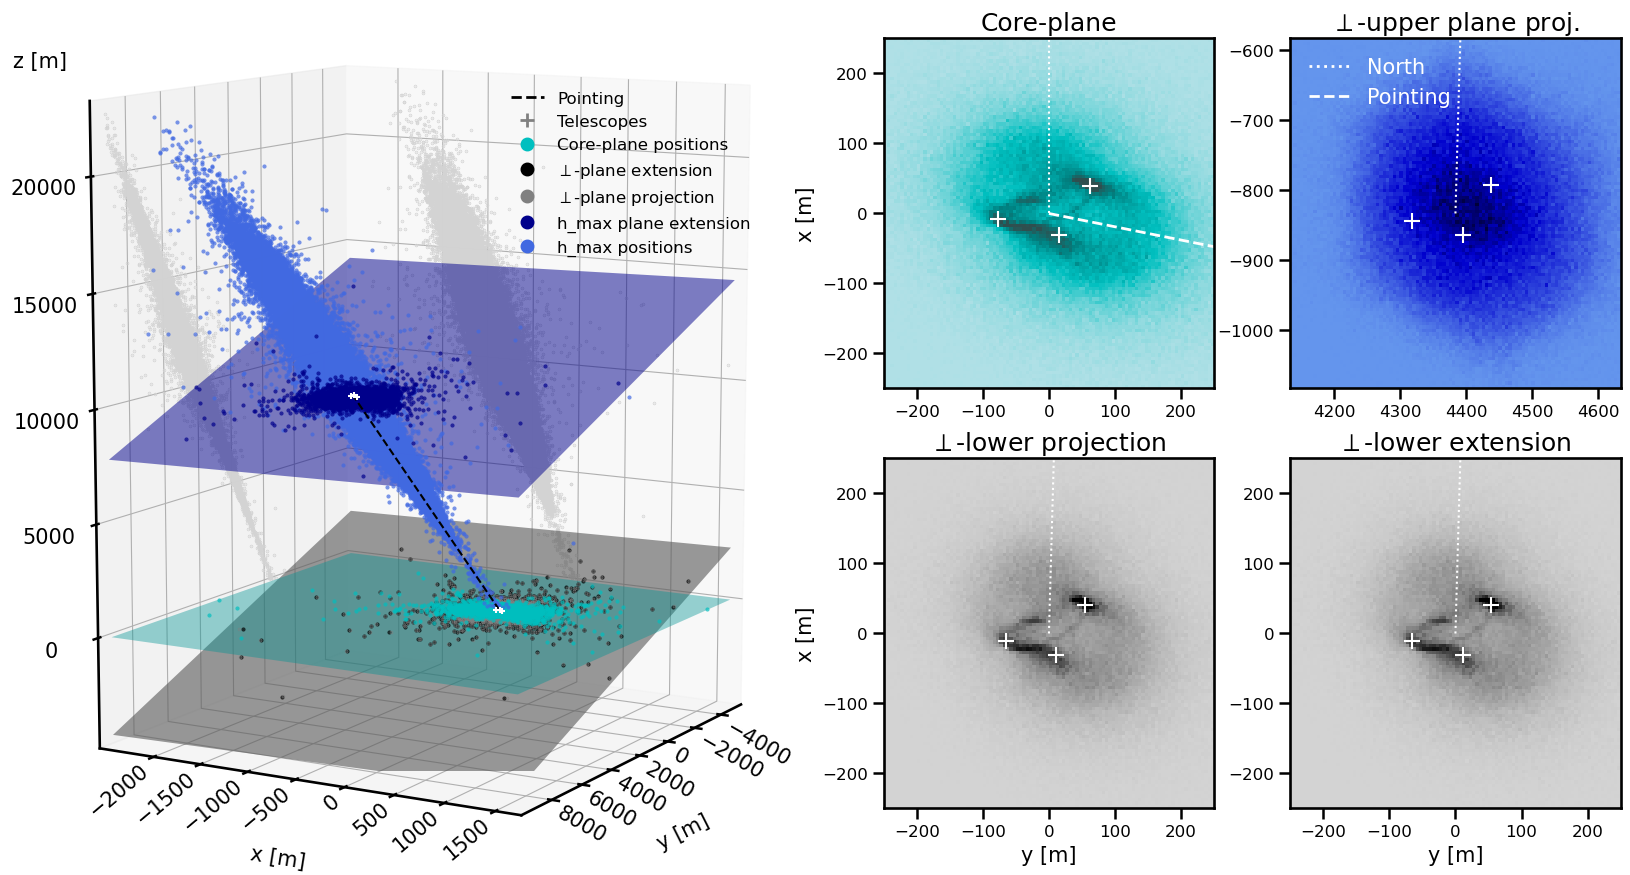

In [4]:
###############################
# PARAMETERS
###############################
c_shower_hmax = 'royalblue'
c_shower_plane, c_shower_part         = 'mediumblue', 'darkblue'
c_core_plane,   c_core_part           = 'c', 'c'
c_proj_plane, c_proj_part, c_ext_part = 'gray', 'gray', 'k'

alpha_core, alpha_proj, alpha_shower = 0.4, 0.6, 0.5


# sigmas to expand the plot
sigmas_plot = [1.2, 2, 3.2]

# size of the histograms
refscale = 250
vmax_core, vmax_hmax, vmax_proj = 250, 200, 350

# colormaps for the histograms
cmap_core = colors.LinearSegmentedColormap.from_list('',  ['powderblue', 'c', 'teal', 'darkslategray'])
cmap_proj = colors.LinearSegmentedColormap.from_list('',   ['lightgray', 'gray', 'k'])
cmap_hmax = colors.LinearSegmentedColormap.from_list('', ['cornflowerblue', 'mediumblue', 'k'])

###############################

fig = plt.figure(figsize=(20,10))
print(f'point_zd={point_zd:.2f}deg, point_az={point_az:.2f}deg')

ax  = fig.add_subplot(121, projection='3d') 
ax1 = fig.add_subplot(243) 
ax2 = fig.add_subplot(244) 
ax3 = fig.add_subplot(247) 
ax4 = fig.add_subplot(248) 

#####################################
# --- plot the reference points --- #
#####################################
ref_points = [[ref_lower[i], ref_upper[i]] for i in range(len(ref_lower))]
ax.plot(*ref_points,                        ls='--', c='k', marker='',  zorder=30, ms=4, lw=1.5, alpha=1)
ax.plot(xpos, ypos, zpos,                   ls='',   c='w', marker='+', zorder=30, ms=4, mew=1.5)
ax.plot(xpos_upper, ypos_upper, zpos_upper, ls='',   c='w', marker='+', zorder=30, ms=4, mew=1.5)
#####################################

###########################################
# --- finding the limits for the plot --- #
###########################################
# finding the limits for a given sigma
lims = aux.lim_plot(ref_lower, ref_upper, factor=sigmas_plot)
xmin, xmax, ymin, ymax, zmin, zmax = lims

print(f'\nThe plotting limits that will be used in the data:')
print(f'xlims:[{xmin:.1f},{xmax:.1f}], ylims:[{ymin:.1f},{ymax:.1f}], zlims:[{zmin:.1f},{zmax:.1f}]')

# setting the limits in x and y
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
###########################################

#############################
# --- create the planes --- #
#############################
# x & y points for the planes
n_points_plane = 2
x_range = np.linspace(xmin, xmax, n_points_plane)
y_range = np.linspace(ymin, ymax, n_points_plane)
X_grid,  Y_grid  = np.meshgrid(x_range, y_range)

# reference planes
core_plane   = geom.z_plane(X_grid, Y_grid, ref_lower, [0, 0])
perp_plane   = geom.z_plane(X_grid, Y_grid, ref_lower, point_dir)
source_plane = geom.z_plane(X_grid, Y_grid, ref_upper, point_dir)

# --- plot the planes --- #
ax.plot_surface(X_grid, Y_grid, perp_plane,   alpha=alpha_proj,   color=c_proj_plane,   zorder=-100)
ax.plot_surface(X_grid, Y_grid, core_plane,   alpha=alpha_core,   color=c_core_plane,   zorder=-50)
ax.plot_surface(X_grid, Y_grid, source_plane, alpha=alpha_shower, color=c_shower_plane, zorder=-60)
#############################

###############################
# --- plotting the points --- #
###############################
# computing the needed masks for our limits
print(f'\nMasking the points within the limits...')
core_mask   = aux.mask_3d(core_x,   core_y,   core_z,   lims)
proj_mask   = aux.mask_3d(proj_x,   proj_y,   proj_z,   lims)
upper_mask  = aux.mask_3d(upper_x,  upper_y,  upper_z,  lims)
lower_mask  = aux.mask_3d(lower_x,  lower_y,  lower_z,  lims)
shower_mask = aux.mask_3d(shower_x, shower_y, shower_z, lims)

cores   = core_x[core_mask],     core_y[core_mask],     core_z[core_mask]
lowers  = lower_x[lower_mask],   lower_y[lower_mask],   lower_z[lower_mask]
projs   = proj_x[proj_mask],     proj_y[proj_mask],     proj_z[proj_mask]
uppers  = upper_x[upper_mask],   upper_y[upper_mask],   upper_z[upper_mask]
showers = shower_x[shower_mask], shower_y[shower_mask], shower_z[shower_mask]

# plotting the points
kw = dict(alpha=0.7, ms=1)
ax.plot(*cores,   'o', color=c_core_part,   **kw, zorder=6)
ax.plot(*lowers,  'o', color=c_ext_part,    **kw, zorder=4)
ax.plot(*projs,   '.', color=c_proj_part,   **kw, zorder=5)
ax.plot(*uppers,  'o', color=c_shower_part, **kw, zorder=10)
ax.plot(*showers, 'o', color=c_shower_hmax, **kw, zorder=9)

# plotting the projection in the axes
kw = dict(color='lightgray', alpha=1, ls='', marker='.', zorder=-20, ms=1)
ax.plot(np.zeros(len(showers[0])) + xmin, showers[1], showers[2], **kw)
ax.plot(showers[0], np.zeros(len(showers[1])) + ymin, showers[2], **kw)
###############################


###################################
# --- plotting the histograms --- #
###################################
# creating colormaps
ranges  = [[-refscale, refscale], [-refscale, refscale]]
ranges2 = [[ref_upper[0]-refscale, ref_upper[0]+refscale], [ref_upper[1]-refscale, ref_upper[1]+refscale]] 

# plotting histograms
Nbins = 100
ax1.hist2d(core_x,  core_y,  range=ranges,  bins=Nbins, cmap=cmap_core, vmax=vmax_core)
ax2.hist2d(upper_x, upper_y, range=ranges2, bins=Nbins, cmap=cmap_hmax, vmax=vmax_hmax)
ax3.hist2d(lower_x, lower_y, range=ranges,  bins=Nbins, cmap=cmap_proj, vmax=vmax_proj)
ax4.hist2d(proj_x,  proj_y,  range=ranges,  bins=Nbins, cmap=cmap_proj, vmax=vmax_proj)

###################################

#################################################
# --- plotting the telescopes in the planes --- #
#################################################
ax1.plot(xpos, ypos,             ls='', c='w', mew=1.5, marker='+', zorder=30, ms=12, lw=2)
ax2.plot(xpos_upper, ypos_upper, ls='', c='w', mew=1.5, marker='+', zorder=30, ms=12, lw=2)
ax3.plot(xpos_lower, ypos_lower, ls='', c='w', mew=1.5, marker='+', zorder=30, ms=12, lw=2)
ax4.plot(xpos_lower, ypos_lower, ls='', c='w', mew=1.5, marker='+', zorder=30, ms=12, lw=2)
#################################################

#######################################
# --- plotting the direction line --- #
#######################################
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]
ax1.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax1), ls='--', lw=2, c='w')
#######################################

############################
# --- projecting north --- #
############################
# calculating projection of north, 
north_point = [0, 1, 0]
proj_north = geom.plane_projection(ref_lower, point_dir, *north_point, *point_dir)

projected_point_dir = np.rad2deg(np.arctan2(proj_north[1], proj_north[0]))

dirs = [90, projected_point_dir, projected_point_dir, projected_point_dir]
for di, axe, init in zip(dirs, [ax1, ax2, ax3, ax4], [init_lower, init_upper, init_lower, init_lower]):
    axe.plot(*geom.line_in_direction(di      , init, axe), ls=':', lw=1.5, c='w')
#     axe.plot(*geom.line_in_direction(di - 180, init, axe), ls=':', lw=1.5, c='w')
############################

##################
# --- others --- #
##################
ax2.plot([], [], ':',  color='w', lw=2, label='North')
ax2.plot([], [], '--', color='w', lw=2, label='Pointing')
ax2.legend(loc=2, frameon=False, labelcolor='w')
titles = ['Core-plane', '$\perp$-upper plane proj.', '$\perp$-lower projection', '$\perp$-lower extension']
for axe, t in zip([ax1, ax2, ax3, ax4], titles):
    axe.set_title(t)
    
for axis1, axis2 in zip([ax3, ax4], [ax1, ax3]):
    axis1.set_xlabel('y [m]')
    axis2.set_ylabel('x [m]')
##################


# creating legends
kw = dict(ls='', marker='o', ms=8)
ax.plot([], [], [], ls='--', color='k', lw=2, label='Pointing')
ax.plot([], [], [], ls='', marker='+', ms=10, mew=2, color='gray', label='Telescopes')
ax.plot([], [], [], c=c_core_part,   **kw, label='Core-plane positions')
ax.plot([], [], [], c=c_ext_part,    **kw, label='$\perp$-plane extension')
ax.plot([], [], [], c=c_proj_part,   **kw, label='$\perp$-plane projection')
ax.plot([], [], [], c=c_shower_part, **kw, label='h_max plane extension')
ax.plot([], [], [], c=c_shower_hmax, **kw, label='h_max positions')
ax.legend(loc=1, frameon=False, fontsize=12)


##################
# --- others --- #
##################
ax.set_xlabel('y [m]')
ax.set_ylabel('x [m]')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('z [m]' + '\n'*32, rotation=0)
ax.xaxis.labelpad = 7
ax.yaxis.labelpad = 5
ax.zaxis.labelpad = 0
ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', rotation=-30, which='major', pad=-7)
ax.tick_params(axis='y', rotation=40, which='major', pad=-7)
for axe in [ax1, ax2, ax3, ax4]:
    axe.tick_params(axis='both', labelsize=12)
for label in ax.get_xticklabels():
    label.set_ha('left')
for label in ax.get_yticklabels():
    label.set_ha('right')
fig.tight_layout()
ax.view_init(10, 30)
ax.set_box_aspect(aspect=(2, 2, 2.7), zoom=1.3)
fig.subplots_adjust(wspace=0.23, hspace=0.2)
##################

plt.savefig(f'{pltpath}mc-planes-projections.png', bbox_inches='tight', dpi=dpi)
plt.show()

## The distances in different planes

In [5]:
# --- selecting file --- #
index_file = 40
print(f'\nThe file selected is:\n{filenames[index_file]}')


The file selected is:
/fefs/aswg/LST1MAGIC/mc/DL2/ST0316A/NSB1.5/GammaTest/v01.2/dec_2276/dl2_gamma_zd_60.528deg_az_175.16deg_LST-1_MAGIC_run107_to_50007.h5


In [6]:
###########################################
# --- telescopes positions extraction --- #
###########################################

tel_positions = SubarrayDescription.from_hdf(filenames[index_file]).positions

coord_t1, coord_t2, coord_t3 = [tel_positions[tel_index].value for tel_index in [1, 2, 3]]

xpos = np.array([tel_positions[i].value[0] for i in [1, 2, 3]])
ypos = np.array([tel_positions[i].value[1] for i in [1, 2, 3]])
zpos = np.array([tel_positions[i].value[2] for i in [1, 2, 3]])

# applying a 90 degree rotation to set the north in the y direction
xpos, ypos = ypos, xpos
xpos = xpos * (-1)

coord_t1 = [xpos[0], ypos[0], zpos[0]]
coord_t2 = [xpos[1], ypos[1], zpos[1]]
coord_t3 = [xpos[2], ypos[2], zpos[2]]

print(f'\nExtracting telescopes positions:')
print(f'LST-1   coords:  [{xpos[0]:.2f}, {ypos[0]:.2f}, {zpos[0]:.2f}] m')
print(f'MAGIC-1 coords:  [{xpos[1]:.2f}, {ypos[1]:.2f}, {zpos[1]:.2f}] m')
print(f'MAGIC-2 coords:  [{xpos[2]:.2f}, {ypos[2]:.2f}, {zpos[2]:.2f}] m')

###########################################

#####################################
# --- dataframes of MC analysis --- #
#####################################
print(f'\nReading .h5 file')
df   = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 1')
dfT1 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 1')
dfT2 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 2')
dfT3 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 3')

# --- dropping non useful columns of the df --- #
del_cols = ['obs_id', 'event_id', 'tel_id', 'n_pixels', 'n_islands', 'magic_stereo', 'intensity', 'skewness',
            'kurtosis', 'x', 'y', 'r', 'length', 'length_uncertainty', 'width', 'width_uncertainty', 
            'intercept', 'deviation', 'slope', 'pixels_width_1', 'pixels_width_2', 'intensity_width_1',
            'intensity_width_2', 'multiplicity', 'combo_type', 'alt_uncert', 'az_uncert', 'true_disp', 
            'off_axis', 'reco_energy_var', 'reco_disp', 'reco_disp_var', 'disp_diff_sum', 'disp_diff_mean',
            'gammaness_var', 'impact', 'true_impact']

df   = df.drop(  del_cols,      axis=1)
dfT1 = dfT1.drop(del_cols[:-2], axis=1)
dfT2 = dfT2.drop(del_cols[:-2], axis=1)
dfT3 = dfT3.drop(del_cols[:-2], axis=1)
#####################################

display(df.head(5))


Extracting telescopes positions:
LST-1   coords:  [-77.13, -8.09, 0.78] m
MAGIC-1 coords:  [62.55, 39.30, -0.97] m
MAGIC-2 coords:  [14.57, -31.21, 0.20] m

Reading .h5 file


,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness
0,0.514383,3.057084,0.937096,29.178182,174.848731,-550.738342,-275.858582,-135.931629,47.232885,28.925041,174.618966,-352.280371,-149.889298,21628.977656,1.039898,29.092358,174.822114,0.931500
3,0.514383,3.057084,0.937096,29.178182,174.848731,99.351418,-28.700325,-108.059178,-70.324472,29.177950,174.876789,99.536352,-23.199455,20974.700369,0.977809,29.220807,174.793392,0.985476
6,0.514383,3.057084,0.142253,29.420948,174.704477,519.278931,-64.852753,-54.842735,-38.344803,29.875659,174.492663,144.074635,-45.298390,22835.628707,0.293451,29.484941,174.721571,0.817095
15,0.514383,3.057084,0.355982,29.072294,175.178315,-74.572876,191.952209,136.812405,-63.109822,29.014835,175.602727,-23.456573,77.802640,20059.408664,0.585457,29.190184,175.154508,0.873833
18,0.514383,3.057084,1.371067,29.687188,175.547815,82.450882,195.357559,63.929800,73.647913,29.579852,174.973947,104.986021,314.025181,24878.178373,1.541227,29.698196,175.549839,0.970833


In [7]:
# --- changing the coordinates --- #

############################################
# --------------- angles ----------------- #
############################################
# extracting pointing direction #
# changing from alt to zd
# changing to az to angle in spherical coordinates
point_zd       = 90 - np.rad2deg(df['pointing_alt'].to_numpy()[0])
point_eq_angle = - np.rad2deg(df['pointing_az'].to_numpy()[0]) + 90
point_az       =   np.rad2deg(df['pointing_az'].to_numpy()[0])

df['pointing_zd']       = point_zd 
df['pointing_eq_angle'] = point_eq_angle
df['pointing_az']       = point_az

point_dir = (point_zd, point_eq_angle)
print(f'The pointing direction is zd = {point_zd:.2f}deg and az = {point_az:.2f}deg')

# reconstructed directions
zd = 90 - df['reco_alt'].to_numpy()
eq_angle = - df['reco_az'].to_numpy() + 90
df['reco_zd'] = zd
df['reco_eq_angle'] = eq_angle

# true directions
true_zd = 90 - df['true_alt'].to_numpy()
true_eq_angle = - df['true_az'].to_numpy() + 90
df['true_zd'] = true_zd
df['true_eq_angle'] = true_eq_angle

############################################

############################################
# -------------- positions --------------- #
############################################

# reconstructed core positions
df['core_x'], df['core_y'] = df['core_y'], df['core_x']
df['core_x'] = df['core_x'].to_numpy() * (-1)

core_x = df['core_x'].to_numpy()
core_y = df['core_y'].to_numpy()
core_z = np.zeros(len(core_x))
df['core_z'] = core_z

# true cores positions
df['true_core_x'], df['true_core_y'] = df['true_core_y'], df['true_core_x']
df['true_core_x'] = df['true_core_x'].to_numpy() * (-1)

true_core_x = df['true_core_x'].to_numpy()
true_core_y = df['true_core_y'].to_numpy()
true_core_z = np.zeros(len(true_core_x))
df['true_core_z'] = true_core_z

# altitude of maximum intensity
h_max = df['h_max'].to_numpy()
############################################

############################################
# ----------- reference points ----------- #
############################################
# reference point for the plane of the telescopes
ref_lower = np.array([0, 0, 0])
# reference point in the mean(h_max) altitude
ref_upper = geom.z_projection(*ref_lower, *point_dir, np.mean(h_max))

print(f'\nRef point for lower plane is [{ref_lower[0]:.1f}, {ref_lower[1]:.1f}, {ref_lower[2]:.1f}]m')
print(f'Ref point for upper plane is [{ref_upper[0]:.1f}, {ref_upper[1]:.1f}, {ref_upper[2]:.1f}]m')
############################################

##################################
# --- telescopes projections --- #
##################################
print(f'\nCalculating the telescope projection in the different planes...')
positions_sets = [[xpos[i], ypos[i], zpos[i]] for i in range(len(xpos))]
t1_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[0], point_zd, point_eq_angle)
t1_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[0], point_zd, point_eq_angle)
t2_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[1], point_zd, point_eq_angle)
t2_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[1], point_zd, point_eq_angle)
t3_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[2], point_zd, point_eq_angle)
t3_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[2], point_zd, point_eq_angle)
xpos_lower, xpos_upper = [t1_lower[0], t2_lower[0], t3_lower[0]], [t1_upper[0], t2_upper[0], t3_upper[0]]
ypos_lower, ypos_upper = [t1_lower[1], t2_lower[1], t3_lower[1]], [t1_upper[1], t2_upper[1], t3_upper[1]]
zpos_lower, zpos_upper = [t1_lower[2], t2_lower[2], t3_lower[2]], [t1_upper[2], t2_upper[2], t3_upper[2]]
##################################

###################################################
# --- calculating plane projections of points --- #
###################################################
print('\nProjecting the points in the planes...')
cores_set      = [core_x, core_y, core_z]
true_cores_set = [true_core_x, true_core_y, true_core_z]
dirs_set       = [zd, eq_angle]
true_dirs_set  = [true_zd, true_eq_angle]

# calculating the projections
proj_set   = geom.plane_projection(ref_lower, point_dir, *cores_set, *point_dir)
lower_set  = geom.plane_projection(ref_lower, point_dir, *cores_set, *dirs_set)
upper_set  = geom.plane_projection(ref_upper, point_dir, *cores_set, *dirs_set)
shower_set = geom.z_projection(*cores_set, *dirs_set, h_max)
true_proj_set  = geom.plane_projection(ref_lower, point_dir, *true_cores_set, *point_dir)
true_lower_set = geom.plane_projection(ref_lower, point_dir, *true_cores_set, *true_dirs_set)
true_upper_set = geom.plane_projection(ref_upper, point_dir, *true_cores_set, *true_dirs_set)

# saving it into the total dataframe
df['proj_x'],   df['proj_y'],   df['proj_z']   = proj_set
df['lower_x'],  df['lower_y'],  df['lower_z']  = lower_set
df['upper_x'],  df['upper_y'],  df['upper_z']  = upper_set
df['shower_x'], df['shower_y'], df['shower_z'] = shower_set
df['true_proj_x'],  df['true_proj_y'],  df['true_proj_z']  = true_proj_set
df['true_lower_x'], df['true_lower_y'], df['true_lower_z'] = true_lower_set
df['true_upper_x'], df['true_upper_y'], df['true_upper_z'] = true_upper_set

# saving it to individual variables
proj_x,   proj_y,   proj_z   = proj_set
lower_x,  lower_y,  lower_z  = lower_set
upper_x,  upper_y,  upper_z  = upper_set
shower_x, shower_y, shower_z = shower_set
true_proj_x,  true_proj_y,  true_proj_z  = true_proj_set
true_lower_x, true_lower_y, true_lower_z = true_lower_set
true_upper_x, true_upper_y, true_upper_z = true_upper_set
###################################################

#########################################
# ------- calculating distances ------- #
#########################################
print('\nCalculating distances...')
df['dist_core']  = geom.dist3d(*cores_set, *true_cores_set)
df['dist_proj']  = geom.dist3d(*proj_set,  *true_proj_set)
df['dist_lower'] = geom.dist3d(*lower_set, *true_lower_set)
df['dist_upper'] = geom.dist3d(*upper_set, *true_upper_set)
#########################################

######################################################
# --- recalculating and adding impact parameters --- #
######################################################
print('\nCalculating impact parameters...')
for tel, dataframe, coord in zip(['1', '2', '3'], [dfT1, dfT2, dfT3], [coord_t1, coord_t2, coord_t3]):
    df[f'impact_{tel}']            = dataframe['impact'].to_numpy()
    df[f'true_impact_{tel}']       = dataframe['true_impact'].to_numpy()
    
    df[f'recal_impact_{tel}']      = geom.line_point_distance(*cores_set,      *dirs_set,      coord)
    df[f'recal_true_impact_{tel}'] = geom.line_point_distance(*true_cores_set, *true_dirs_set, coord)
    
    df[f'error_impact_A_{tel}'] = np.array(df[f'true_impact_{tel}']       - df[f'impact_{tel}'])  
    df[f'error_impact_B_{tel}'] = np.array(df[f'recal_true_impact_{tel}'] - df[f'recal_impact_{tel}'])
    df[f'error_impact_C_{tel}'] = np.array(df[f'recal_impact_{tel}']      - df[f'impact_{tel}'])    
    df[f'error_impact_D_{tel}'] = np.array(df[f'recal_true_impact_{tel}'] - df[f'true_impact_{tel}'])
######################################################

####################################
# --- calculating other errors --- #
####################################
df['error_zd'] = df['true_zd'] - df['reco_zd']
df['error_az'] = df['true_az'] - df['reco_az']
####################################

# deleting redundant variables
del cores_set,      proj_set,      lower_set,      upper_set,      dirs_set,     shower_set
del true_cores_set, true_proj_set, true_lower_set, true_upper_set, true_dirs_set
del positions_sets

display(df.head(5))

The pointing direction is zd = 60.53deg and az = 175.16deg

Ref point for lower plane is [0.0, 0.0, 0.0]m
Ref point for upper plane is [3483.5, -41122.0, 23322.4]m

Calculating the telescope projection in the different planes...

Projecting the points in the planes...

Calculating distances...

Calculating impact parameters...


,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness,pointing_zd,pointing_eq_angle,reco_zd,reco_eq_angle,true_zd,true_eq_angle,core_z,true_core_z,proj_x,proj_y,proj_z,lower_x,lower_y,lower_z,upper_x,upper_y,upper_z,shower_x,shower_y,shower_z,true_proj_x,true_proj_y,true_proj_z,true_lower_x,true_lower_y,true_lower_z,true_upper_x,true_upper_y,true_upper_z,dist_core,dist_proj,dist_lower,dist_upper,impact_1,true_impact_1,recal_impact_1,recal_true_impact_1,error_impact_A_1,error_impact_B_1,error_impact_C_1,error_impact_D_1,impact_2,true_impact_2,recal_impact_2,recal_true_impact_2,error_impact_A_2,error_impact_B_2,error_impact_C_2,error_impact_D_2,impact_3,true_impact_3,recal_impact_3,recal_true_impact_3,error_impact_A_3,error_impact_B_3,error_impact_C_3,error_impact_D_3,error_zd,error_az
0,0.514383,175.15799,0.937096,29.178182,174.848731,275.858582,-550.738342,-135.931629,47.232885,28.925041,174.618966,149.889298,-352.280371,21628.977656,1.039898,29.092358,174.822114,0.931500,60.528002,-85.15799,60.907642,-84.822114,60.821818,-84.848731,0.0,0.0,126.622684,-77.620965,-155.773583,124.919524,-76.730518,-153.949163,3863.390215,-41332.012109,22895.295858,3657.999822,-39065.460039,21628.977656,239.260405,-118.701537,-245.030462,236.815745,-117.649110,-242.809687,3952.976245,-41339.784868,22868.210234,235.061326,149.471268,148.631384,93.913277,262.226642,407.301703,263.579347,412.184519,145.075060,148.605172,1.352705,4.882817,198.140799,337.021299,199.401427,335.329501,138.880500,135.928073,1.260628,-1.691798,191.930135,337.518855,193.132370,339.478281,145.588720,146.345912,1.202234,1.959426,-0.085825,0.026617
3,0.514383,175.15799,0.937096,29.178182,174.848731,28.700325,99.351418,-108.059178,-70.324472,29.177950,174.876789,23.199455,99.536352,20974.700369,0.977809,29.220807,174.793392,0.985476,60.528002,-85.15799,60.779193,-84.793392,60.821818,-84.848731,0.0,0.0,29.419424,26.110416,41.643653,29.903206,25.968533,41.321227,3784.318053,-41175.456814,23183.143932,3426.031093,-37243.570214,20974.700369,34.878799,26.415322,41.365840,35.291504,26.237652,40.990930,3751.452004,-41195.898106,23152.010852,5.503978,5.474936,5.405116,49.671846,119.278722,104.797537,119.404620,124.223054,-14.481185,4.818434,0.125898,19.425517,46.429150,49.839205,46.406536,42.354542,3.410055,-4.051994,-0.022614,-7.484663,66.122623,53.015836,66.247313,67.710013,-13.106787,1.462700,0.124690,14.694177,0.042625,0.055339
6,0.514383,175.15799,0.142253,29.420948,174.704477,64.852753,519.278931,-54.842735,-38.344803,29.875659,174.492663,45.298390,144.074635,22835.628707,0.293451,29.484941,174.721571,0.817095,60.528002,-85.15799,60.515059,-84.721571,60.579052,-84.704477,0.0,0.0,54.238250,38.540727,59.853748,55.040799,38.623028,59.878990,3851.233062,-41051.272068,23392.111475,3760.692409,-40071.262179,22835.628707,97.605561,132.636204,219.285128,100.683772,132.703828,218.944596,3911.545282,-40982.067878,23505.123708,375.713504,190.139547,190.358465,145.597213,152.880076,296.415597,152.127456,314.700295,143.535521,162.572840,-0.752621,18.284698,54.088876,227.162266,53.513688,240.077283,173.073390,186.563595,-0.575188,12.915017,97.561940,269.918867,96.421001,285.238819,172.356926,188.817818,-1.140939,15.319952,0.063994,-0.017093
15,0.514383,175.15799,0.355982,29.072294,175.178315,-191.952209,-74.572876,136.812405,-63.109822,29.014835,175.602727,-77.802640,-23.456573,20059.408664,0.585457,29.190184,175.154508,0.873833,60.528002,-85.15799,60.809816,-85.154508,60.927706,-85.178315,0.0,0.0,-78.877805,-10.764385,-7.198398,-78.881567,-10.729171,-7.135746,3416.781096,-41246.785700,23112.273064,2955.186936,-35801.659919,20059.408664,-195.669515,-30.690557,-24.887937,-195.668542,-30.516228,-24.580707,3286.893389,-41315.842943,23009.911841,125.071982,119.792636,119.729077,179.213669,8.294884,142.156010,8.353820,123.271500,133.861126,114.917680,0.058936,-18.884510,146.776418,285.203865,147.1042

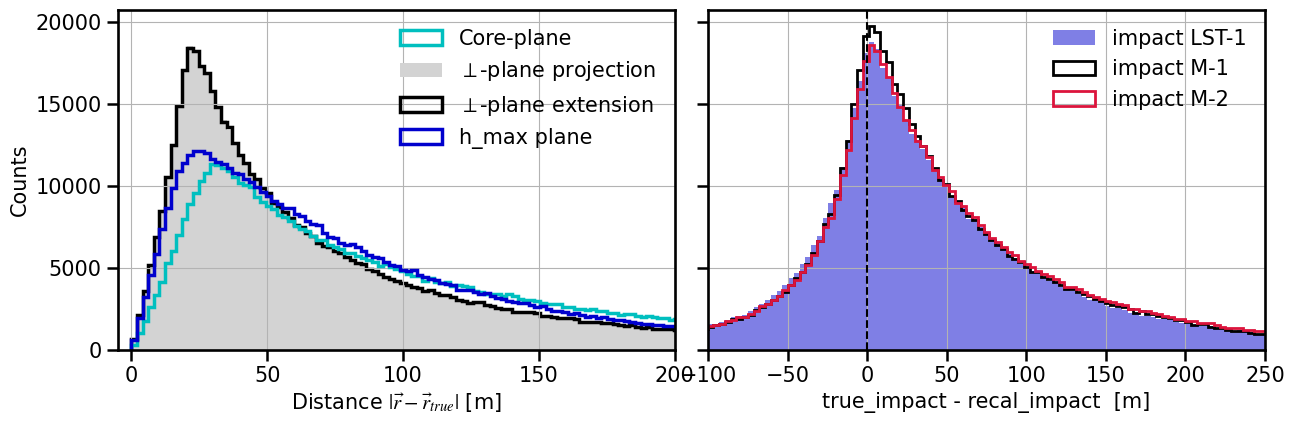

In [9]:
bins1 = np.linspace(0,204,100)
bins2 = np.linspace(-104,254,100)


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,4.5), sharey=True)

lab = ['Core-plane', '$\perp$-plane projection', '$\perp$-plane extension', 'h_max plane']
ax1.hist(df['dist_core'],  bins=bins1, label=lab[0], histtype='step', color='c', lw=2.5)
ax1.hist(df['dist_proj'],  bins=bins1, label=lab[1], histtype='stepfilled', color='lightgray', zorder=-2)
ax1.hist(df['dist_lower'], bins=bins1, label=lab[2], histtype='step',       color='k', lw=2.5, zorder=-1)
ax1.hist(df['dist_upper'], bins=bins1, label=lab[3], histtype='step',       color='mediumblue',     lw=2.5)

kws = [dict(histtype='stepfilled', color='mediumblue', alpha=0.5), 
       dict(histtype='step', color='k'), 
       dict(histtype='step', color='crimson')]

for tel, lab, kw in zip([1,2,3], ['impact LST-1', 'impact M-1', 'impact M-2'], kws):
    ax2.hist(df[f'error_impact_A_{tel}'], bins=bins2, **kw, label=lab, lw=2)
ax2.axvline(0, ls='--', color='k', lw=1.5)
ax2.set_xlabel('true_impact - recal_impact  [m]')
ax2.legend(frameon=False, loc=1)
    
ax1.legend(frameon=False, loc=1)
ax1.set_xlabel('Distance $|\\vec{r}-\\vec{r}_{true}|$ [m]')
ax1.set_ylabel('Counts')
fig.tight_layout()
ax1.grid(color='0.7')
ax2.grid(color='0.7')
ax1.set_xlim(-5, 200)
ax2.set_xlim(-100, 250)

plt.savefig(f'{pltpath}mc-planes-distances.pdf', bbox_inches='tight', dpi=dpi)
plt.show()